In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import rotate
from skimage.color import rgb2gray
from deskew import determine_skew

import pytesseract
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import RANSACRegressor
import seaborn as sns

from os import listdir
from os.path import isfile, join
import imutils

# Reading Data

Text(0.5, 1.0, 'origin image')

<Figure size 720x720 with 0 Axes>

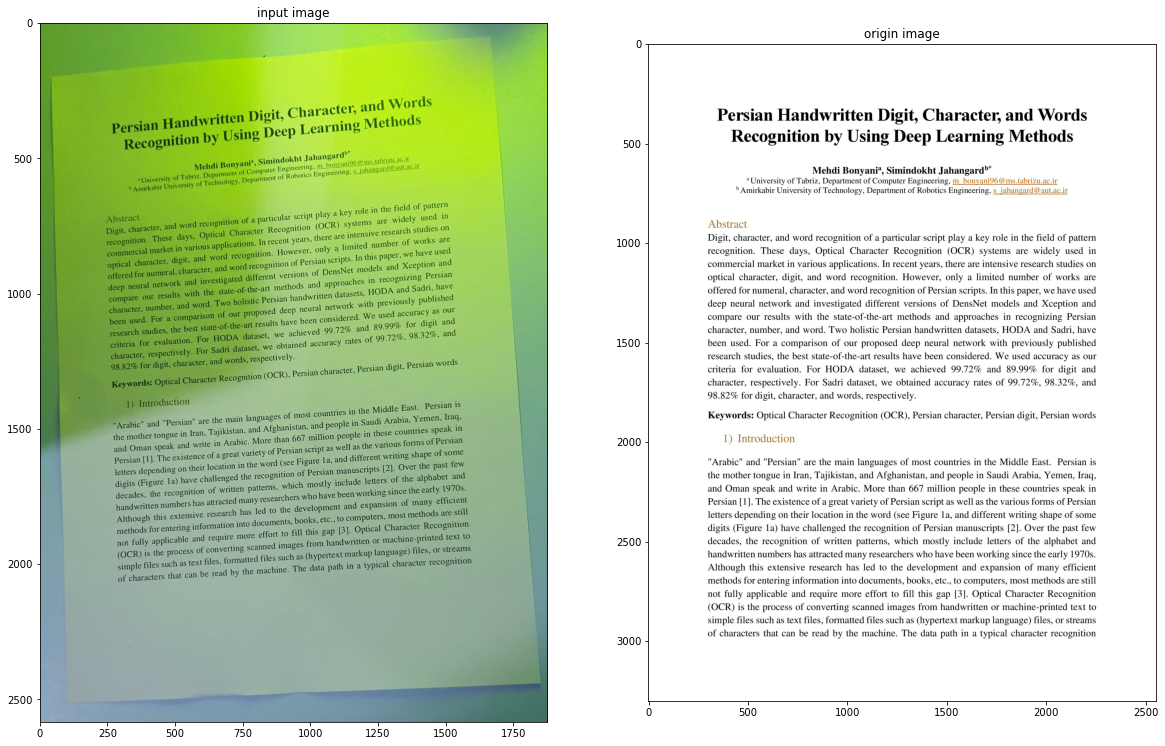

In [2]:
image = 1
mypath = '../data/imagesprojets5/photo/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

img_file = onlyfiles[4]
origin_file = '../data/imagesprojets5/originals/image_1.jpg' #original image

img = cv2.imread(mypath + img_file) #reading the image
origin = cv2.imread(origin_file) #reading the original image

plt.figure(figsize=(10,10))
plt.rcParams["figure.figsize"] = [20,20]

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(img)
ax1.set_title('input image')
ax2.imshow(origin)
ax2.set_title('origin image')

# Removing shadows

Text(0.5, 1.0, 'result_planes')

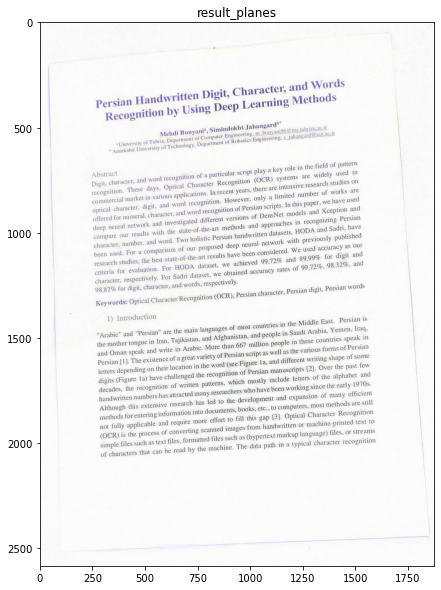

In [3]:
def remove_shadows(img):
    """
    Removes shadows from an image
    """
    rgb_planes = cv2.split(img) # split RGB colors 
    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8)) # dilation
        bg_img = cv2.medianBlur(dilated_img, 21) # median bluring
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1) #normalize
        result_planes.append(diff_img)
        result_norm_planes.append(norm_img)

    result_ = cv2.merge(result_planes)
#     result_norm = cv2.merge(result_norm_planes)
    return result_

result = remove_shadows(img)

plt.figure(figsize=(10,10))
plt.rcParams["figure.figsize"] = [20,20]


plt.imshow(result)
plt.title('result_planes')


# Start preprocessing 

In [4]:
image = result.copy()
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) # convert to grayscale

kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0) # apply gaussian blur

low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold) # Find edges using canny

Text(0.5, 1.0, 'Image after detecting edges')

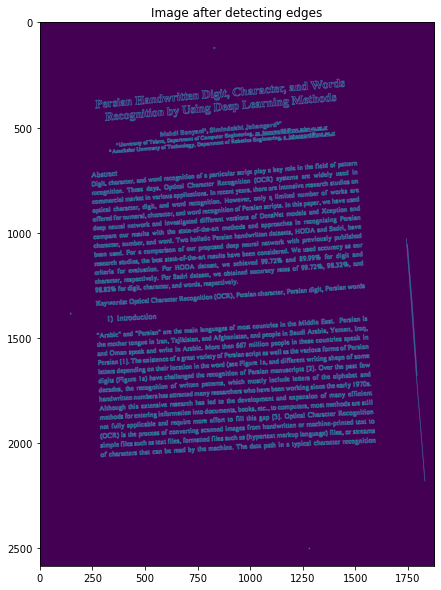

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(edges)
plt.title('Image after detecting edges')

## Run Probabilistic Houghline transform to detect lines

Text(0.5, 1.0, 'Image Line Detection')

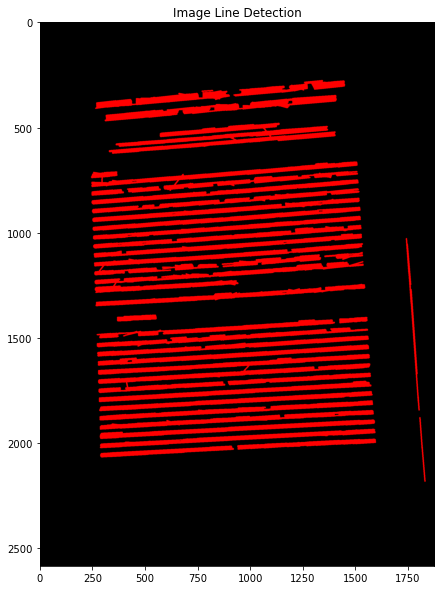

In [24]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image_b = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_b,(x1,y1),(x2,y2),(255,0,0),5)
plt.figure(figsize=(10,10))
plt.imshow(line_image_b)
plt.title('Image Line Detection')

### Solution  
- Find the direction of the image 
- find the image contours with auto-completion
- compute the homography matrix
- apply the homography transformation on the image

In [7]:
def deskew(_img):
    #image = io.imread(_img)
    grayscale = rgb2gray(_img)
    angle = determine_skew(grayscale)
    rotated = rotate(_img, angle, resize=True) * 255
    print(angle)
    return angle,rotated.astype(np.uint8)

In [8]:
def display_avant_apres(_original):
    plt.subplot(1, 2, 1)
    plt.imshow(_original)
    plt.subplot(1, 2, 2)
    plt.imshow(deskew(_original)[1])

Using deskew we find the rotation of the image.

In [9]:
angle_desk,rotated  = deskew(result)

-4.022346368715105


Text(0.5, 1.0, 'Rotation result using only a 2D rotation')

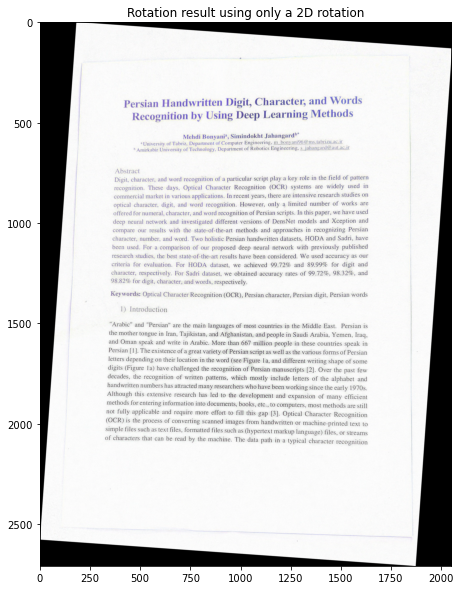

In [10]:
plt.figure(figsize = (15,10))
plt.imshow(rotated)
plt.title('Rotation result using only a 2D rotation')

This result is sub-optimal as we can see that there is still some depth effect to the image (text in the bottom is larger the the text in the top)

We will use the previous results to draw a contour around the text in the image 

# Filtering lines

In [12]:
def detect_hough_lines_and_filter_them(edges):
    """
    Detect Probabilistic Hough lines and drop lines with a small prjection on the x axis 
    """
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 15  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 50  # minimum number of pixels making up a line
    max_line_gap = 20  # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)

    # removing small lines
    lines_tmp = []
    for line in lines : 
        for x1,y1,x2,y2 in line :
            if abs(x2-x1)>10: # we remove lines with small projection on the x axis (less than 10 pixels)
                lines_tmp.append(np.array([[x1,y1,x2,y2]]))
    lines_tmp = np.array(lines_tmp)
    lines = lines_tmp.copy()
    return lines
lines = detect_hough_lines_and_filter_them(edges)

Here we compute the polar coordinates of each line (angle)

In [19]:
# computing angles
def compute_angles(lines):
    """
    Compute angles in degrees given lines
    """
    angles = []
    for line in lines : 
        for x1,y1,x2,y2 in line:
            ang = np.arctan((x1-x2)/(y2-y1)) # angle of rotation of the line (y2-y1 because the y axis is inverted (L-y))
            angles.append(ang)
    angles = np.array(angles)

    #converting angles to degree
    angles_deg_ = np.rad2deg(angles)
    return angles_deg_

angles_deg = compute_angles(lines)

def adjust_angles(angles_deg):
    """
    Adjusting the angles to between 0 and 90 degrees, we use the same logic as the one used in deskew library
    """
    # adjusting angles (from deskew repo)
    rot_angles_ = []
    for angle in angles_deg:
        if 0 <= angle <= 90:
            rot_angle = angle - 90
        elif -45 <= angle < 0:
            rot_angle = angle - 90
        elif -90 <= angle < -45:
            rot_angle = 90 + angle
        rot_angles_.append(rot_angle)
    rot_angles_ = np.array(rot_angles_)
    return rot_angles_
    
rot_angles = adjust_angles(angles_deg)

<ipython-input-19-80a442f23c46>:9: RuntimeWarning: divide by zero encountered in int_scalars
  ang = np.arctan((x1-x2)/(y2-y1)) # angle of rotation of the line (y2-y1 because the y axis is inverted (L-y))


(-30.0, 30.0)

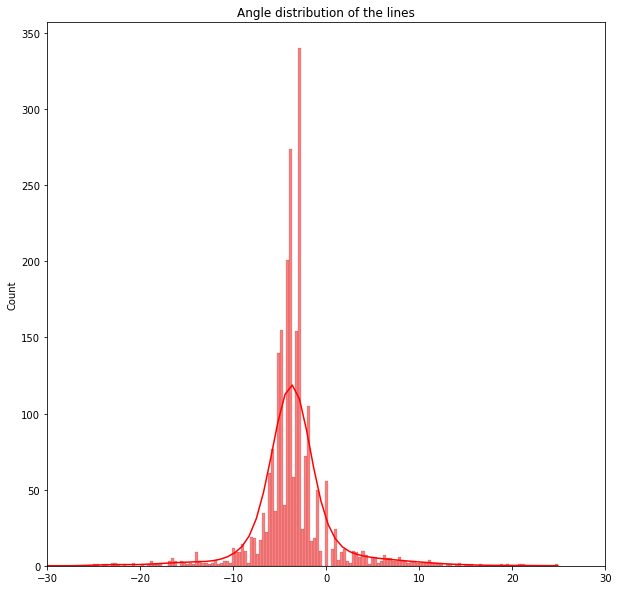

In [20]:
plt.figure(figsize=(10,10))
sns.histplot(rot_angles,kde=True,color='r')
plt.title('Angle distribution of the lines')
plt.xlim(-30,30)

In [21]:
print(f'We know that the rotation angle of the image on the 2D image is around {np.round(angle_desk,2)} degrees, we use this information to only keep lines with a similar angular rotation')

We know that the rotation angle of the image on the 2D image is around -4.02 degrees, we use this information to only keep lines with a similar angular rotation


In [22]:
# filtering and only keeping lines with the same angle
def filter_lines(lines,rot_angles,angle_desk):
    thresh = 5
    lines_r = lines.reshape(lines.shape[0],4)
    mask = (rot_angles>=angle_desk-abs(angle_desk))*(rot_angles<=angle_desk+abs(angle_desk)) # filtering the desired lines
    lines_candidates_ = lines_r[mask,:]

    lines_candidates_ = lines_candidates_.reshape(lines_candidates_.shape[0],1,lines_candidates_.shape[1])
    return lines_candidates_
lines_candidates = filter_lines(lines,rot_angles,angle_desk)

Text(0.5, 1.0, 'Result after filtering the lines with the same angle')

<Figure size 1080x720 with 0 Axes>

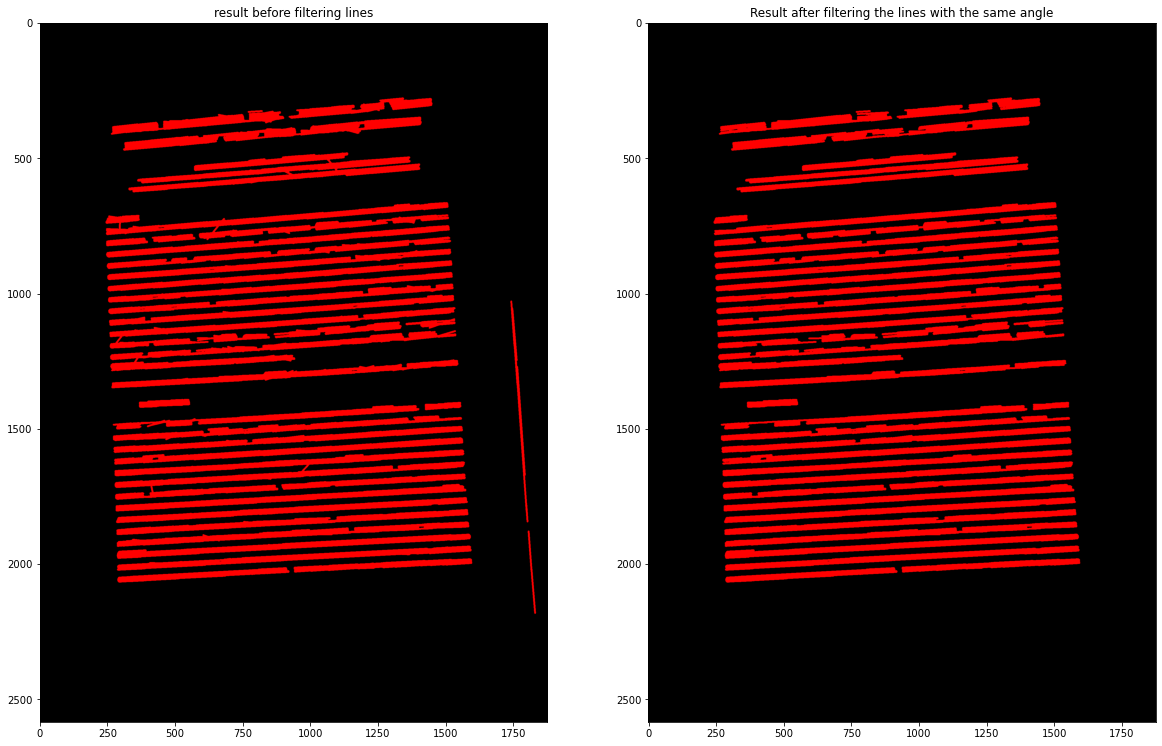

In [26]:
line_image_candidates = np.copy(img) * 0  # creating a blank to draw lines on
for line in lines_candidates:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_candidates,(x1,y1),(x2,y2),(255,0,0),5)
plt.figure(figsize=(15,10))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(line_image_b)
ax1.set_title('result before filtering lines')
ax2.imshow(line_image_candidates)
ax2.set_title('Result after filtering the lines with the same angle')

From here, we will use the resulting lines to draw the contour. <br>
A first approximation is by taking the max, min coordinates of the lines : 

In [29]:
# perfect rectangle
lines_candidates_r = lines_candidates.reshape(lines_candidates.shape[0],4)

def find_perfect_rectangle(lines_candidates_r):
    """
    Find a rectangle box from the given points
    """
    x = np.concatenate([lines_candidates_r[:,0],lines_candidates_r[:,2]])
    y = np.concatenate([lines_candidates_r[:,1],lines_candidates_r[:,3]])
    x_max      = x.max()
    x_max_arg  = x.argmax()%lines_candidates_r.shape[0]
    x_min      = x.min()
    x_min_arg  = x.argmin()%lines_candidates_r.shape[0]

    y_max      = y.max()
    y_max_arg  = y.argmax()%lines_candidates_r.shape[0]
    y_min      = y.min()
    y_min_arg  = y.argmin()%lines_candidates_r.shape[0]
    return x_max,x_max_arg,x_min,x_min_arg,y_max,y_max_arg,y_min,y_min_arg

x_max,x_max_arg,x_min,x_min_arg,y_max,y_max_arg,y_min,y_min_arg = find_perfect_rectangle(lines_candidates_r) 

Text(0.5, 1.0, 'Drawing rectangular contour using the min max coordinates of the lines')

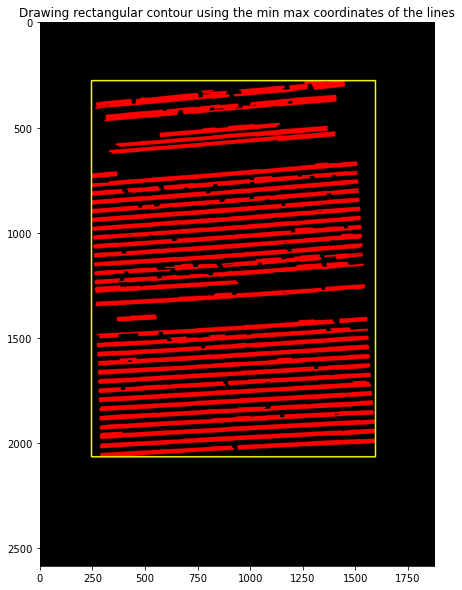

In [30]:
# plotting image with rectangular contour (min max of the lines)
line_image_candidates = np.copy(img) * 0  # creating a blank to draw lines on
for line in lines_candidates[:]:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_candidates,(x1,y1),(x2,y2),(255,0,0),5)

cv2.line(line_image_candidates,(x_min,y_min),(x_max,y_min),(255,255,0),5)
cv2.line(line_image_candidates,(x_min,y_max),(x_max,y_max),(255,255,0),5)
cv2.line(line_image_candidates,(x_min,y_min),(x_min,y_max),(255,255,0),5)
cv2.line(line_image_candidates,(x_max,y_min),(x_max,y_max),(255,255,0),5)


plt.figure(figsize=(15,10))
plt.imshow(line_image_candidates)
plt.title('Drawing rectangular contour using the min max coordinates of the lines')

We can see that this result is bad and doesn't give an accurate contour, we will use a different approach.

# Dropping outlier lines

Here the idea is to drop lines that aren't part of the text, if a line is not part of the text its y coordinates should be far from the coordinates of the text and should be considered as an outlier. <br>
We use an isolation Forest to remove the outliers

In [32]:
# create a binary thresholded image
_, binary = cv2.threshold(gray, 225, 255, cv2.THRESH_BINARY_INV)

# find the contours from the thresholded image
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# draw all contours
result_outlier = result.copy()
img_outlier = cv2.drawContours(result_outlier, contours, -1, (0, 255, 0), 2)
gray_outlier = cv2.cvtColor(img_outlier,cv2.COLOR_BGR2GRAY)

kernel_size = 5
blur_gray = cv2.GaussianBlur(gray_outlier,(kernel_size, kernel_size),0)
low_threshold = 50
high_threshold = 150
edges_outlier = cv2.Canny(blur_gray, low_threshold, high_threshold)

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines_outlier = cv2.HoughLinesP(edges_outlier, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

In [35]:
def label_outliers(lines_outlier):
    X_train = lines_outlier[:,:,3]
    clf = IsolationForest(max_samples=100,contamination=0.01) # consider 1% of the lines as outliers
    clf.fit(X_train)
    labels_ = clf.predict(X_train)
    return labels_

labels = label_outliers(lines_outlier)

Text(0.5, 1.0, 'Image with outlier lines')

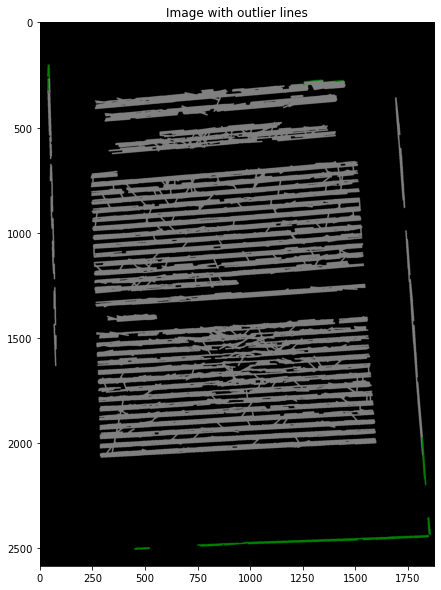

In [36]:
line_image_candidates = np.copy(img_outlier) * 0  # creating a blank to draw lines on
i=0
colors = {-1:(0,128,0),0:(128,128,0),1:(128,128,128)}
for line in lines_outlier[:]:
    for x1,y1,x2,y2 in line:
        c = labels[i]
        if c in colors.keys():
            cv2.line(line_image_candidates,(x1,y1),(x2,y2),colors[c],5)
        else:
            cv2.line(line_image_candidates,(x1,y1),(x2,y2),(255,255,255),5)
    i+=1
plt.figure(figsize=(15,10))
plt.imshow(line_image_candidates)
plt.title('Image with outlier lines')

In [37]:
lines_outlier = lines_outlier[labels!=-1] #removing outlier lines

<ipython-input-38-9a7869be94bd>:15: RuntimeWarning: divide by zero encountered in int_scalars
  b = y2 - x2*(y2-y1)/(x2-x1)


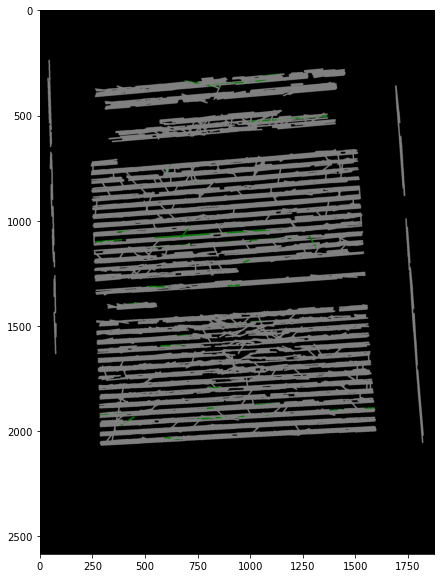

In [38]:
# removing outliers 
line_image_candidates = np.copy(img) * 0  # creating a blank to draw lines on
absis = [] #compute the absis of each line
i = 0
colors = {-1:(0,128,0),0:(128,128,0),1:(128,128,128)}
for line in lines_outlier[:]:
    for x1,y1,x2,y2 in line:
        c = labels[i]
        if c in colors.keys():
            cv2.line(line_image_candidates,(x1,y1),(x2,y2),colors[c],5)
        else:
            cv2.line(line_image_candidates,(x1,y1),(x2,y2),(255,255,255),5)
            
            
        b = y2 - x2*(y2-y1)/(x2-x1)
    
        absis.append(b)
    i+=1
absis = np.array(absis)
plt.figure(figsize=(15,10))
plt.imshow(line_image_candidates)

The outliers have been removed from the image

# Image skewed to left
In the following we consider that the image is always skewed to the left, if it's skewed to the right we will flip it to the left (symmetric rotation). <br>
The goal is to find the four corners of the text. <br> We initialize the 4 corners points with the regular rectangle, we will be updating these solutions in the following :


In [39]:
def compute_line_equation(l):
    """
    Compute the line equation from 2 points of a line
    """
    x1,y1,x2,y2 = l
    y1 = L - y1 # inverse y axis to start from 0 to L 
    y2 = L - y2
    
    a = (y2-y1)/(x2-x1)
    b = y2 - x2*a
    return a,b

# initialize the 4 corners points with the regular rectangle, we will be updating these solutions in the following :
x_low_right,y_low_right,x_low_left,y_low_left = x_max,y_max,x_min,y_max
x_top_right,y_top_right,x_top_left,y_top_left = x_max,y_min,x_min,y_min


## Get longest lines

In [59]:
def compute_distance(l):
    """
    Compute the euclidian length of a line
    """
    return np.sqrt((l[0]-l[2])**2+(l[1]-l[3])**2)

percentile_thresh = 75
def get_longest_lines(lines_candidates,percentile_thresh=75):
    distances = np.apply_along_axis(compute_distance, 1, lines_candidates.reshape(-1,4)) # compute length of the lines

    index_sorting = np.argsort(distances) #sort the index lines based on their distances 
    sorted_distances = np.array(sorted(distances)) # sort distances

    max_index = (sorted_distances[sorted_distances >= np.percentile(sorted_distances,percentile_thresh)]).shape[0] #take the top 25 longest lines
    longest_lines_indexs = index_sorting[-max_index:] # get longest lines indexes
    longest_lines_ = lines_candidates[longest_lines_indexs,:,:] # get longest lines
    return longest_lines_
longest_lines = get_longest_lines(lines_candidates, percentile_thresh=75)

Text(0.5, 1.0, 'Result after keeping the top 25% lines')

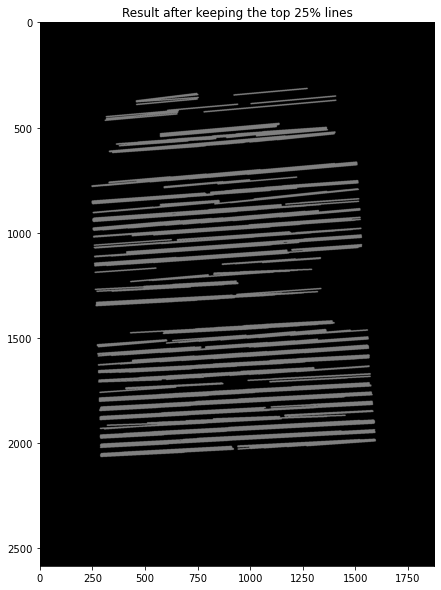

In [60]:
line_image_candidates = np.copy(img) * 0  # creating a blank to draw lines on
for line in longest_lines[:]:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_candidates,(x1,y1),(x2,y2),(128, 128, 128),5)
plt.figure(figsize=(15,10))
plt.imshow(line_image_candidates)          
plt.title(f'Result after keeping the top {100-percentile_thresh}% lines')

## Finding the surroundings lines
### Right vertical line

In [128]:
#### Draw the line on the right going through all edges
# for each y2 of a line, there is no other line with x2 higher

# find line with x2 maximum take it and drop it and only keep lines with y2 lower than its y 
# repeat from the list until there is no other line 

candidates = []
lines = lines_candidates_r.copy()

while len(lines)>0:
    first_line = lines[lines.argmax(axis=0)[2],:]
    candidates.append(first_line)
    y = first_line[3]
    lines = lines[lines[:,3]<y]

In [129]:
candidates = np.array(candidates).reshape(len(candidates),1,4)

Text(0.5, 1.0, 'Keeping the top right lines')

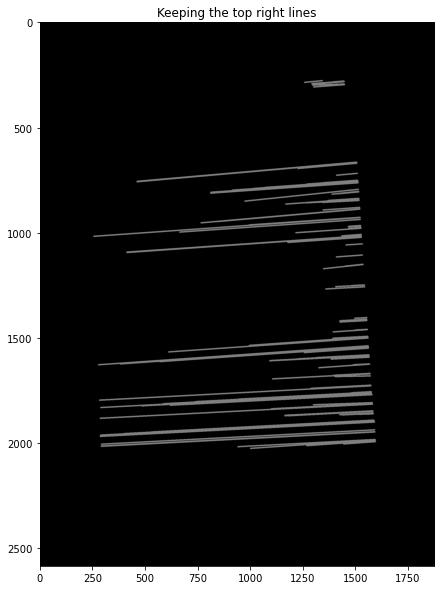

In [130]:
line_image_candidates = np.copy(img) * 0  # creating a blank to draw lines on
for line in candidates[:]:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_candidates,(x1,y1),(x2,y2),(128, 128, 128),5)
plt.figure(figsize=(15,10))
plt.imshow(line_image_candidates)          
plt.title('Keeping the top right lines')

Now we fit a robust linear regression (RANSAC Regression) to the y coordinates of these points in order to remove outliers (text in the middle of the image)

In [131]:
L = img.shape[0]

In [132]:
X_rv = candidates[:,:,2]
Y_rv = candidates[:,:,3]

model = RANSACRegressor()
model.fit(X_rv, Y_rv)
y_pred_rv = model.predict(X_rv).astype(int)

Text(0.5, 1.0, 'Robust Regression Model of the y coordinates of the lines in the right edge')

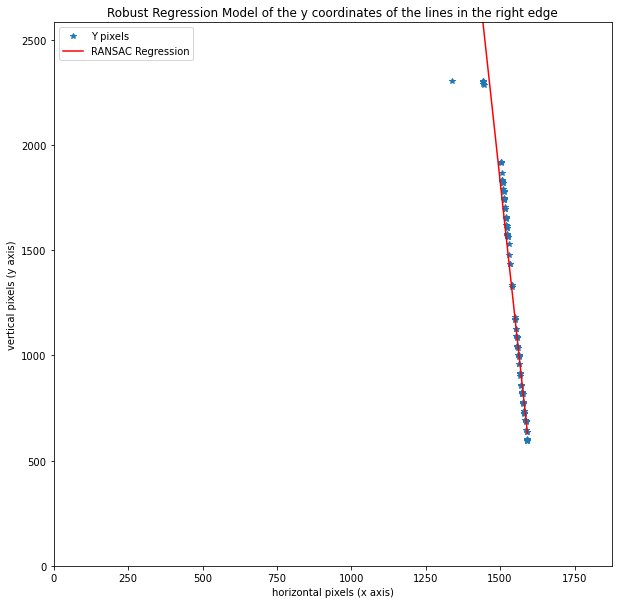

In [133]:
plt.figure(figsize=(10,10))
plt.plot(candidates[:,:,2],L- candidates[:,:,3],'*',label = 'Y pixels')
plt.plot(X_rv,L-y_pred_rv,label='RANSAC Regression',color = 'red')
plt.legend()
plt.xlabel('horizontal pixels (x axis)')
plt.ylabel('vertical pixels (y axis)')
plt.xlim(0,img.shape[1])
plt.ylim(0,img.shape[0])


plt.title('Robust Regression Model of the y coordinates of the lines in the right edge')

Text(0.5, 1.0, 'Drawing the fitted line crossing the right edges of the text')

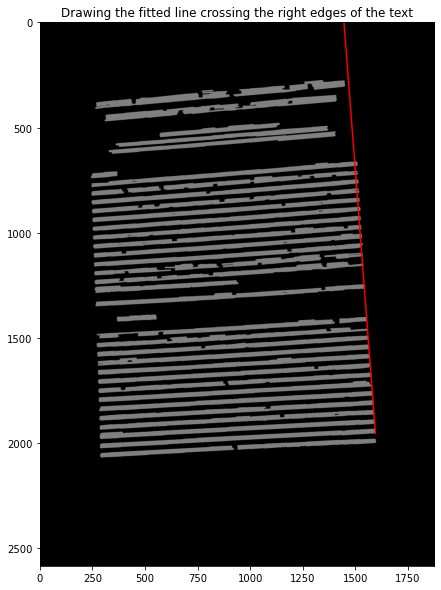

In [134]:
line_image_candidates = np.copy(img) * 0  # creating a blank to draw lines on
for line in lines_candidates[:]:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_candidates,(x1,y1),(x2,y2),(128, 128, 128),5)
cv2.line(line_image_candidates,(X_rv[0][0],y_pred_rv[0][0]),(X_rv[-1][0],y_pred_rv[-1][0]),(255, 0, 0),5)

plt.figure(figsize=(15,10))
plt.imshow(line_image_candidates)          
plt.title('Drawing the fitted line crossing the right edges of the text')

Now we will do the same thing to fit the horizontal line crossing all the y edges   

Text(0.5, 1.0, 'Keeping the top horizontal lines')

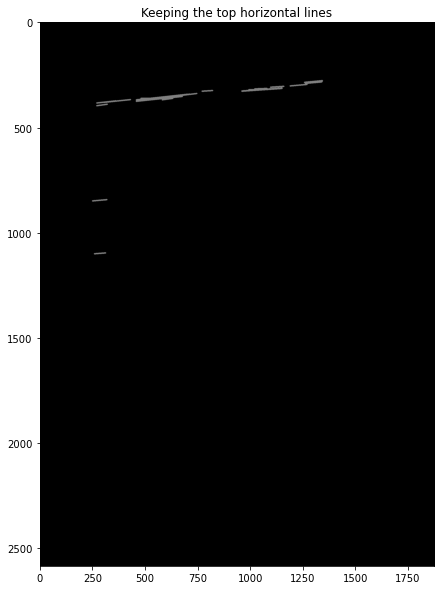

In [135]:
#### Draw the line horizontal on the top going through all y edges
# for each x2 of a line, there is no other line with y2 lower

# find line with y2 minimal take it and drop it and only keep lines with x2 lower than its x 
# repeat from the list until there is no other line 

candidates = []
lines = lines_candidates_r.copy()

while len(lines)>0:
    first_line = lines[lines.argmin(axis=0)[3],:]
    candidates.append(first_line)
    x = first_line[2]
    lines = lines[lines[:,2]<x]
    
candidates = np.array(candidates).reshape(len(candidates),1,4)

line_image_candidates = np.copy(img) * 0  # creating a blank to draw lines on
for line in candidates[:]:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_candidates,(x1,y1),(x2,y2),(128, 128, 128),5)
plt.figure(figsize=(15,10))
plt.imshow(line_image_candidates)          
plt.title('Keeping the top horizontal lines')

In [136]:
X_th = candidates[:,:,2]
Y_th = candidates[:,:,3]

model = RANSACRegressor()
model.fit(Y_th, X_th)
x_pred_th = model.predict(Y_th).astype(int)

Text(0.5, 1.0, 'Robust Regression Model of the y coordinates of the lines in the right edge')

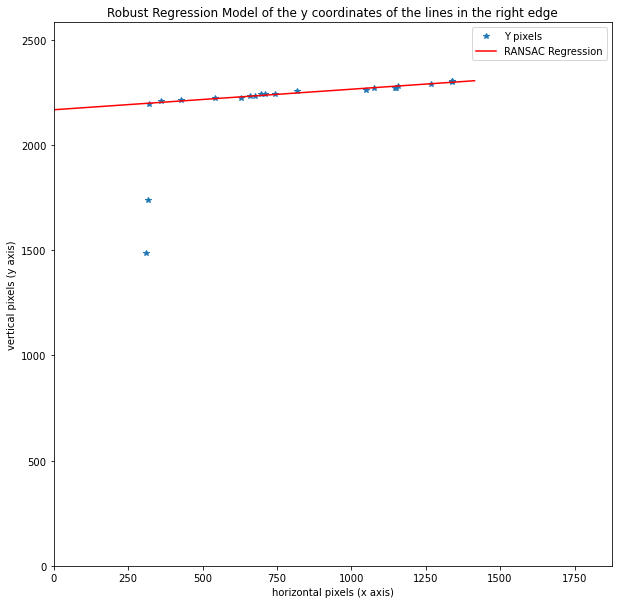

In [137]:
plt.figure(figsize=(10,10))
plt.plot(candidates[:,:,2],L-candidates[:,:,3],'*',label = 'Y pixels')
plt.plot(x_pred_th,L-Y_th,label='RANSAC Regression',color = 'red')
plt.legend()
plt.xlabel('horizontal pixels (x axis)')
plt.ylabel('vertical pixels (y axis)')
plt.ylim(0,img.shape[0])
plt.xlim(0,img.shape[1])

plt.title('Robust Regression Model of the y coordinates of the lines in the right edge')

Text(0.5, 1.0, 'Drawing the fitted line crossing the right edges of the text')

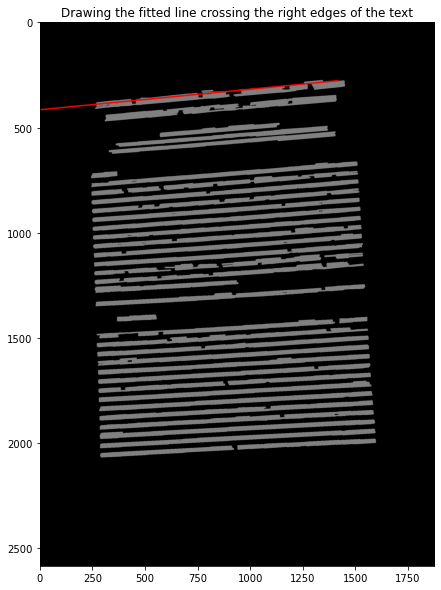

In [138]:
line_image_candidates = np.copy(img) * 0  # creating a blank to draw lines on
for line in lines_candidates[:]:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_candidates,(x1,y1),(x2,y2),(128, 128, 128),5)
cv2.line(line_image_candidates,(x_pred_th[0][0],Y_th[0][0]),(x_pred_th[-1][0],Y_th[-1][0]),(255, 0, 0),5)

plt.figure(figsize=(15,10))
plt.imshow(line_image_candidates)          
plt.title('Drawing the fitted line crossing the right edges of the text')

Now that we have fitted the line on the right edges, we will find the intersection of this line with the line with the lowest y, the result is the top right corner

## Left vertical line : fitting another regression to the left side

In [139]:
#### Draw the line on the left going through all edges
# for each x1 of a line, there is no other line with y_2 lower

# find line with x1 minimal take it and drop it and only keep lines with y2 higher than its y 
# repeat from the list until there is no other line 

candidates = []
lines = lines_candidates_r.copy()

while len(lines)>0:

    first_line = lines[lines.argmin(axis=0)[0],:]
    candidates.append(first_line)
    y = first_line[1]
    lines = lines[lines[:,1]>y]

In [140]:
candidates = np.array(candidates).reshape(len(candidates),1,4)

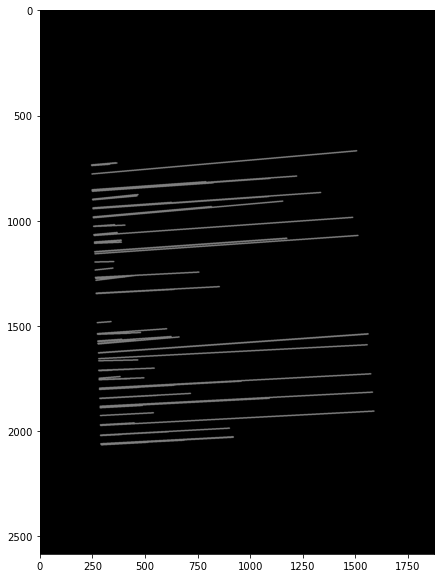

In [141]:
line_image_candidates = np.copy(img) * 0  # creating a blank to draw lines on
for line in candidates[:]:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_candidates,(x1,y1),(x2,y2),(128, 128, 128),5)
plt.figure(figsize=(15,10))
plt.imshow(line_image_candidates)          
            

In [142]:
X_lv = candidates[:,:,0]
Y_lv = candidates[:,:,1]

model = RANSACRegressor()
model.fit(X_lv, Y_lv)
y_pred_lv = model.predict(X_lv).astype(int)

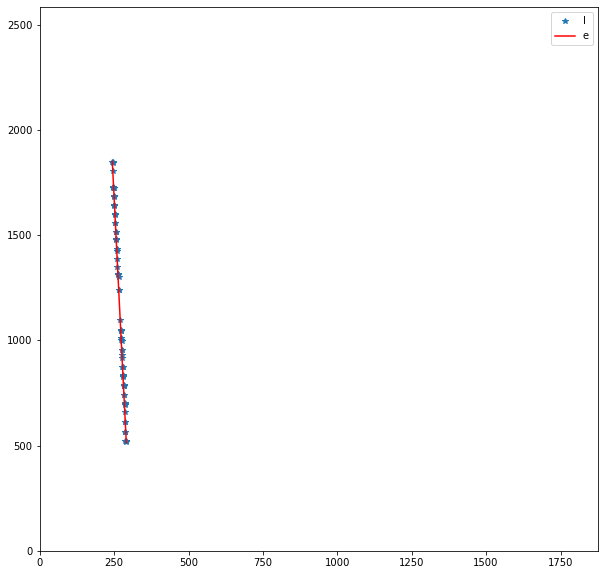

In [143]:
plt.figure(figsize=(10,10))
plt.plot(candidates[:,:,0],L- candidates[:,:,1],'*',label = 'Y pixels')
plt.plot(X_lv,L-y_pred_lv,label='RANSAC Regression',color = 'red')
plt.legend()
plt.ylim(0,img.shape[0])
plt.xlim(0,img.shape[1])

plt.legend('left vertical line')

Text(0.5, 1.0, 'Fitting a line on the left vertical edges')

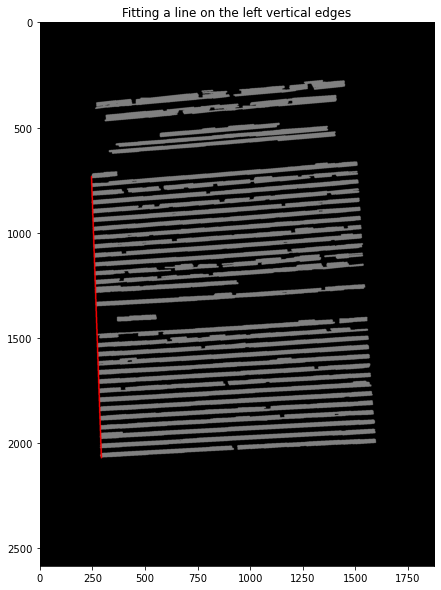

In [144]:
line_image_candidates = np.copy(img) * 0  # creating a blank to draw lines on
for line in lines_candidates[:]:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_candidates,(x1,y1),(x2,y2),(128, 128, 128),5)
        
cv2.line(line_image_candidates,(X_lv[0][0],y_pred_lv[0][0]),(X_lv[-1][0],y_pred_lv[-1][0]),(255, 0, 0),5)

plt.figure(figsize=(15,10))
plt.imshow(line_image_candidates)          
plt.title('Fitting a line on the left vertical edges')

## Fiiting a last line on the low horizontal edges

Text(0.5, 1.0, 'Keeping the lower horizontal lines')

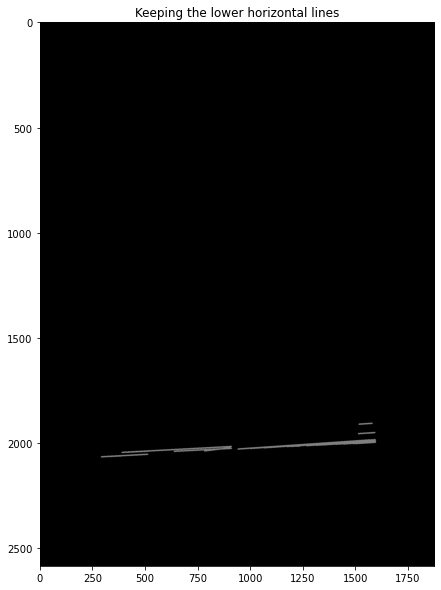

In [145]:
#### Draw the horizontal line on the low going through all y edges
# for each y1 of a line, there is no other line with x1 lower

# find line with y1 maximal take it and drop it and only keep lines with x1 higher than its x 
# repeat from the list until there is no other line 

candidates = []
lines = lines_candidates_r.copy()

while len(lines)>0:
    first_line = lines[lines.argmax(axis=0)[1],:]
    candidates.append(first_line)
    x = first_line[0]
    lines = lines[lines[:,0]>x]
    
candidates = np.array(candidates).reshape(len(candidates),1,4)

line_image_candidates = np.copy(img) * 0  # creating a blank to draw lines on
for line in candidates[:]:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_candidates,(x1,y1),(x2,y2),(128, 128, 128),5)
plt.figure(figsize=(15,10))
plt.imshow(line_image_candidates)          
plt.title('Keeping the lower horizontal lines')

In [146]:
X_lh = candidates[:,:,0]
Y_lh = candidates[:,:,1]

model = RANSACRegressor()
model.fit(Y_lh, X_lh)
x_pred_lh = model.predict(Y_lh).astype(int)

Text(0.5, 1.0, 'Robust Regression Model of the y coordinates of the lines in the low horizontal edge')

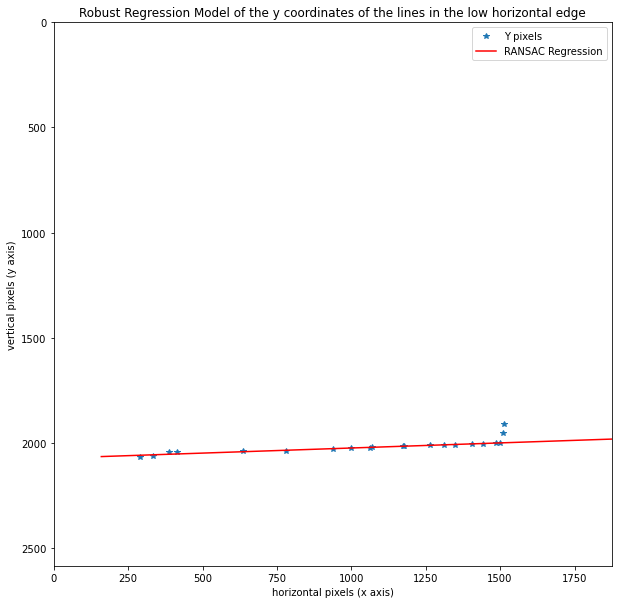

In [147]:
plt.figure(figsize=(10,10))
plt.plot(candidates[:,:,0],candidates[:,:,1],'*',label = 'Y pixels')
plt.plot(x_pred_lh,Y_lh,label='RANSAC Regression',color = 'red')
plt.legend()
plt.xlabel('horizontal pixels (x axis)')
plt.ylabel('vertical pixels (y axis)')
plt.ylim(img.shape[0],0)
plt.xlim(0,img.shape[1])


plt.title('Robust Regression Model of the y coordinates of the lines in the low horizontal edge')

Text(0.5, 1.0, 'Drawing the fitted line crossing the right edges of the text')

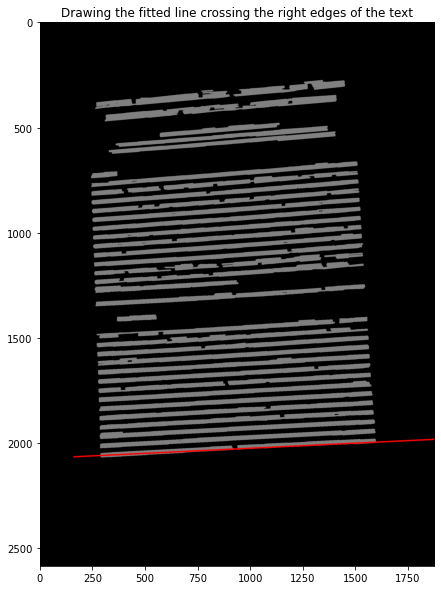

In [148]:
line_image_candidates = np.copy(img) * 0  # creating a blank to draw lines on
for line in lines_candidates[:]:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_candidates,(x1,y1),(x2,y2),(128, 128, 128),5)
cv2.line(line_image_candidates,(x_pred_lh[0][0],Y_lh[0][0]),(x_pred_lh[-1][0],Y_lh[-1][0]),(255, 0, 0),5)

plt.figure(figsize=(15,10))
plt.imshow(line_image_candidates)          
plt.title('Drawing the fitted line crossing the right edges of the text')

# Combining everything together

Text(0.5, 1.0, 'Combining all the fitted lines')

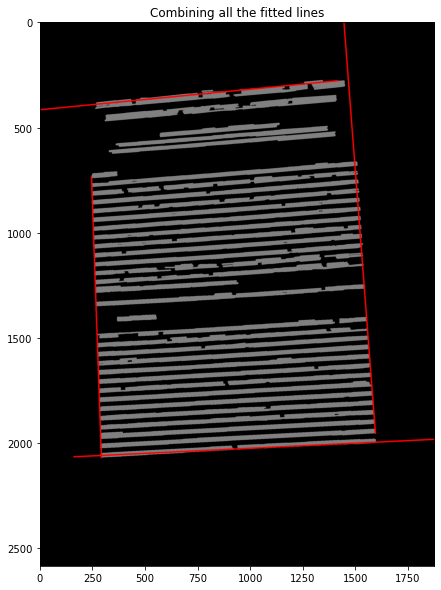

In [149]:
line_image_candidates = np.copy(img) * 0  # creating a blank to draw lines on
for line in lines_candidates[:]:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_candidates,(x1,y1),(x2,y2),(128, 128, 128),5)
cv2.line(line_image_candidates,(x_pred_lh[0][0],Y_lh[0][0]),(x_pred_lh[-1][0],Y_lh[-1][0]),(255, 0, 0),5)
cv2.line(line_image_candidates,(X_lv[0][0],y_pred_lv[0][0]),(X_lv[-1][0],y_pred_lv[-1][0]),(255, 0, 0),5)
cv2.line(line_image_candidates,(X_rv[0][0],y_pred_rv[0][0]),(X_rv[-1][0],y_pred_rv[-1][0]),(255, 0, 0),5)
cv2.line(line_image_candidates,(x_pred_th[0][0],Y_th[0][0]),(x_pred_th[-1][0],Y_th[-1][0]),(255, 0, 0),5)

plt.figure(figsize=(15,10))
plt.imshow(line_image_candidates)          
plt.title('Combining all the fitted lines')

# Finding the corners using the intersection of the lines

Now that we have found the 4 border lines, we can find the four corners using the intersection of those lines.

In [152]:
def compute_intersection(b1,b2,a1,a2):
    x_inter = (b1-b2)/(a2-a1)
    y_inter = L - int(a2*x_inter + b2)
    x_inter = int(x_inter)
    print('x,y intersection :',x_inter,y_inter)
    return x_inter,y_inter

model_line_lh = np.array([x_pred_lh[0][0],Y_lh[0][0],x_pred_lh[-1][0],Y_lh[-1][0]]) # low horizontal line
model_line_lv = np.array([X_lv[0][0],y_pred_lv[0][0],X_lv[-1][0],y_pred_lv[-1][0]]) # left vertical line
model_line_rv = np.array([X_rv[0][0],y_pred_rv[0][0],X_rv[-1][0],y_pred_rv[-1][0]]) # right vertical line
model_line_th = np.array([x_pred_th[0][0],Y_th[0][0],x_pred_th[-1][0],Y_th[-1][0]]) # top horizontal line

a_m_lh,b_m_lh = compute_line_equation(model_line_lh) # low horizontal line
a_m_lv,b_m_lv = compute_line_equation(model_line_lv) # left vertical line
a_m_rv,b_m_rv = compute_line_equation(model_line_rv) # right vertical line
a_m_th,b_m_th = compute_line_equation(model_line_th) # top horizontal line


x_top_left,y_top_left = compute_intersection(b_m_lv,b_m_th,a_m_lv,a_m_th)  
x_low_left,y_low_left = compute_intersection(b_m_lv,b_m_lh,a_m_lv,a_m_lh)  
x_top_right,y_top_right = compute_intersection(b_m_rv,b_m_th,a_m_rv,a_m_th) 
x_low_right,y_low_right = compute_intersection(b_m_rv,b_m_lh,a_m_rv,a_m_lh) 

x,y intersection : 232 394
x,y intersection : 290 2058
x,y intersection : 1463 274
x,y intersection : 1595 1995


Let's check the results

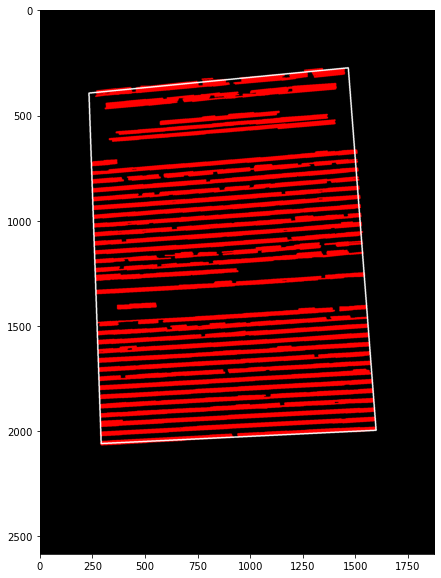

In [153]:
line_image_candidates = np.copy(img) * 0  # creating a blank to draw lines on
for line in lines_candidates[:]:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_candidates,(x1,y1),(x2,y2),(255,0,0),5)

cv2.line(line_image_candidates,(x_low_right,y_low_right),(x_low_left,y_low_left),(255,255,255),5)
cv2.line(line_image_candidates,(x_top_right,y_top_right),(x_top_left,y_top_left),(255,255,255),5)
cv2.line(line_image_candidates,(x_low_right,y_low_right),(x_top_right,y_top_right),(255,255,255),5)
cv2.line(line_image_candidates,(x_low_left,y_low_left),(x_top_left,y_top_left),(255,255,255),5)


plt.figure(figsize=(15,10))
plt.imshow(line_image_candidates)

## Adjusting the image 

Now that we have the four corners of our text, we will use these points to redress the image into a rectangular shape using the homography transformation

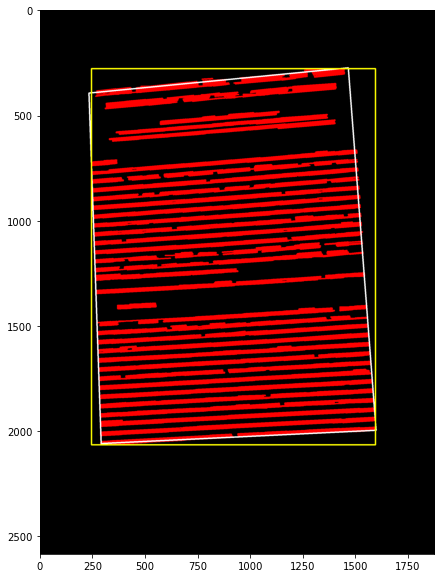

In [154]:
line_image_candidates = np.copy(img) * 0  # creating a blank to draw lines on
for line in lines_candidates[:]:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_candidates,(x1,y1),(x2,y2),(255,0,0),5)
        
cv2.line(line_image_candidates,(x_low_right,y_low_right),(x_low_left,y_low_left),(255,255,255),5)
cv2.line(line_image_candidates,(x_top_right,y_top_right),(x_top_left,y_top_left),(255,255,255),5)
cv2.line(line_image_candidates,(x_low_right,y_low_right),(x_top_right,y_top_right),(255,255,255),5)
cv2.line(line_image_candidates,(x_low_left,y_low_left),(x_top_left,y_top_left),(255,255,255),5)

cv2.line(line_image_candidates,(x_min,y_min),(x_max,y_min),(255,255,0),5)
cv2.line(line_image_candidates,(x_min,y_max),(x_max,y_max),(255,255,0),5)
cv2.line(line_image_candidates,(x_min,y_min),(x_min,y_max),(255,255,0),5)
cv2.line(line_image_candidates,(x_max,y_min),(x_max,y_max),(255,255,0),5)

plt.figure(figsize=(15,10))
plt.imshow(line_image_candidates)

In [155]:
dest = np.array([(x_min,y_min),
                 (x_min,y_max),
                 (x_max,y_min),
                 (x_max,y_max)
                ])
src =  np.array([(x_top_left,y_top_left),
                 (x_low_left,y_low_left),
                 (x_top_right,y_top_right),
                 (x_low_right,y_low_right)
                ])

h, status = cv2.findHomography(src, dest,cv2.RANSAC, 5.0)
print(h)

In [156]:
dd

[[ 1.16272997e+00 -3.21237166e-02 -8.00760524e+00]
 [ 1.21705578e-01  1.16255157e+00 -2.02482885e+02]
 [ 3.33810210e-05  3.32796386e-05  1.00000000e+00]]


In [157]:
im_out = cv2.warpPerspective(result,h,(result.shape[1], result.shape[0]))

Text(0.5, 1.0, 'The whole image adjusted')

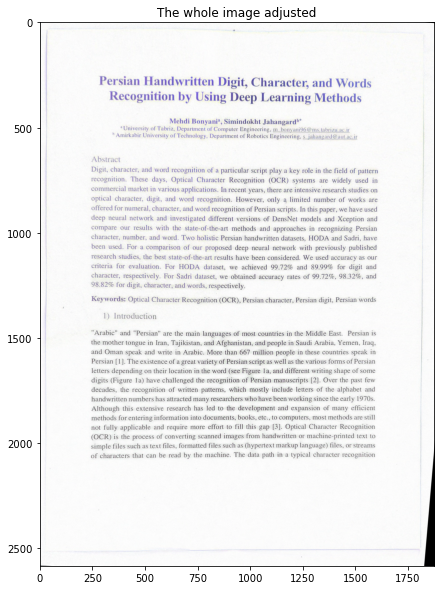

In [158]:
plt.figure(figsize=(15,10))
plt.imshow(im_out)
plt.title('The whole image adjusted')

Text(0.5, 1.0, 'Text area adjusted using the 4 corners + a buffer of 100 px')

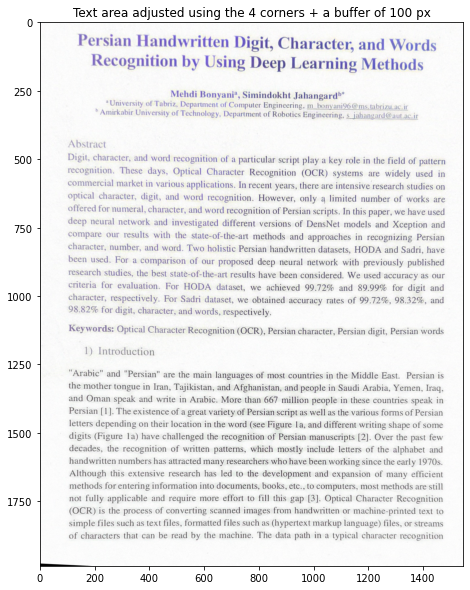

In [159]:
buffer = 100
x_border_min,x_border_max = min(x_top_left,x_low_left,x_top_right,x_low_right)-buffer,max(x_top_left,x_low_left,x_top_right,x_low_right)+buffer
y_border_min,y_border_max = min(y_top_left,y_low_left,y_top_right,y_low_right)-buffer,max(y_top_left,y_low_left,y_top_right,y_low_right)+buffer
# (result_norm.shape[1], result_norm.shape[0])
im_out = cv2.warpPerspective(result[y_border_min:y_border_max,x_border_min:x_border_max],h,(2*buffer + x_max-x_min, 2*buffer + y_max-y_min))
plt.figure(figsize=(15,10))
plt.imshow(im_out)
plt.title('Text area adjusted using the 4 corners + a buffer of 100 px')

### Result comparison
We compare the results of our method vs only using deskew which gives a 2D rotation instead of a 3D homography transformation.

Text(0.5, 1.0, 'result using our method')

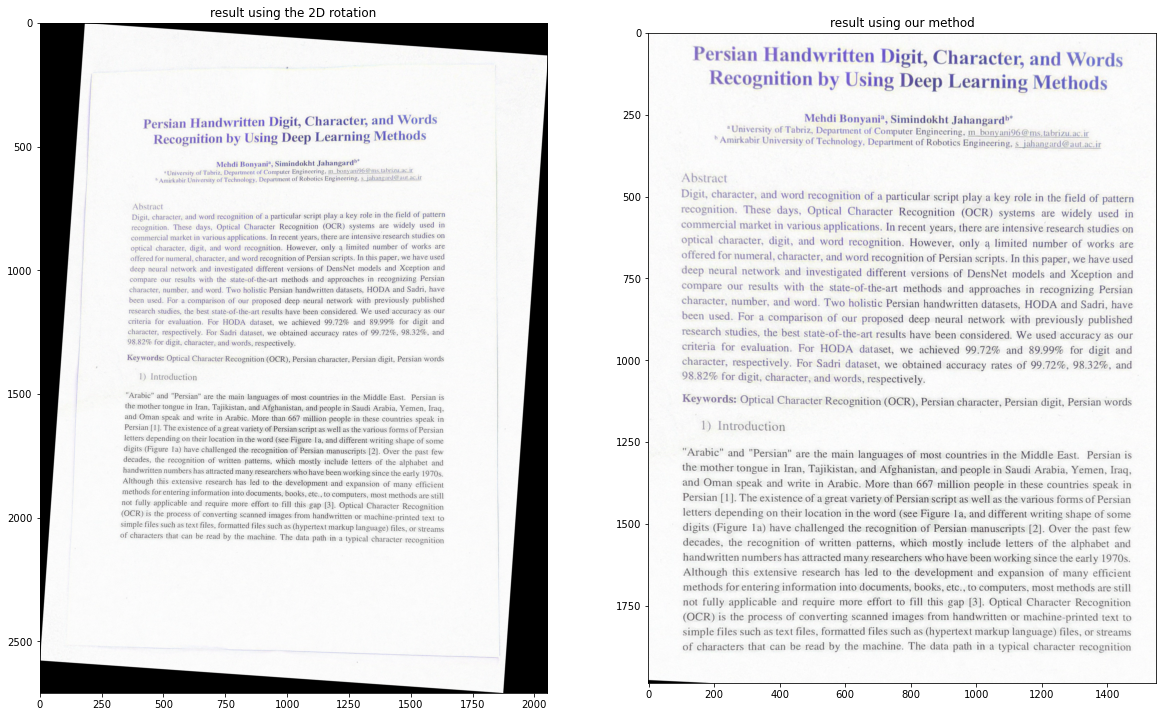

In [160]:
# plt.figure(figsize=(10,10))
plt.rcParams["figure.figsize"] = [20,20]

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(rotated)
ax1.set_title('result using the 2D rotation')
ax2.imshow(im_out)
ax2.set_title('result using our method')

### Pytesseract : Extract distances 

Now that we have redressed the image, we go back to the text extraction using pytesseract.

Text(0.5, 1.0, 'Text and distances extracted using pytesseract')

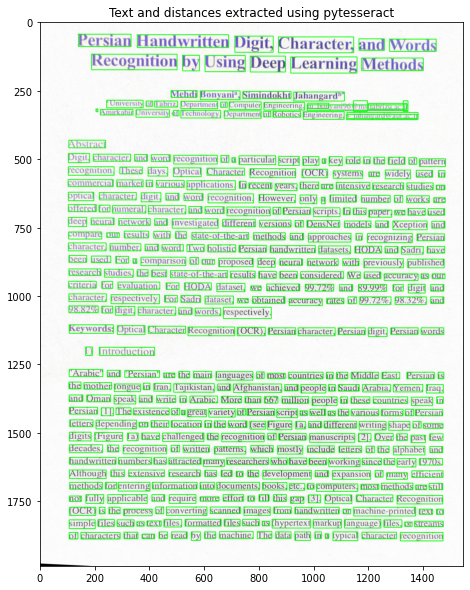

In [161]:
plt.rcParams["figure.figsize"] = [15,10]

im_tesseract = im_out.copy()
d = pytesseract.image_to_data(im_tesseract, output_type=pytesseract.Output.DICT)
n_boxes = len(d['level'])
level = 5
words_coords = []
for i in range(n_boxes):
    if d['level'][i] == level:
        word = {}
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        word['x'] = x
        word['y'] = y
        word['w'] = w
        word['h'] = h
        word['text'] = d['text'][i]
        words_coords.append(word)
        cv2.rectangle(im_tesseract, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.imshow(im_tesseract)
plt.title('Text and distances extracted using pytesseract')